# Reading Single Day of Data

Getting things set up

In [287]:
import pandas as pd
import numpy as np
import seaborn
from bokeh import palettes
from bokeh.charts import Bar
import math
from IPython.display import Image

In [6]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [7]:
%matplotlib inline

The below file is a sample day of data stored as an HDF5 file. It can be read as a DataFrame.

In [8]:
file = r'D:\ADSB\working\h5\2017-01-16.h5'

In [9]:
store = pd.HDFStore(file)

In [10]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: D:\ADSB\working\h5\2017-01-16.h5
/data            frame_table  (typ->appendable,nrows->273664,ncols->60,indexers->[index],dc->[Alt,Cou,FSeen,PosTime,From,Icao,Id,Lat,Long,Mil,To,Type,Op,OpIcao,Help,Stops])

How many rows are in the file?

In [11]:
store.get_storer('data').nrows

273664

And how many unique aircraft reports?

In [14]:
len(store['data']['Icao'].unique())

25951

And how many of the rows contain lat/long/alt?

In [565]:
store['data']['Lat'].count(), store['data']['Long'].count(), store['data']['Alt'].count()

(230254, 230254, 267175)

What about Manufacturer or Aircraft Type?

In [15]:
store['data']['Man'].count(),store['data']['Type'].count()

(253076, 252946)

In [16]:
day_of_data_df = store['data']

Below is a Pivot Table showing the number of unique aircraft and the number of unique aircraft manufacturers by Airaft Country (where it is registered).

In [17]:
pd.pivot_table(day_of_data_df,values=['Id','Man'],index='Cou', 
               aggfunc=lambda x: len(x.unique())).sort_values(by='Id',ascending=False)[:30]

,Id,Man
Cou,,
United States,7258,120
Unknown or unassigned country,4600,4
China,1437,7
United Kingdom,1242,100
Germany,1043,54
Canada,808,42
France,578,46
Australia,573,41
Ireland,567,21


## Airfraft Manufacturers 

In [121]:
aircraft_df = day_of_data_df[['Id','Cou','Year','Man','Type']].dropna(how='all')
aircraft_df = aircraft_df.drop_duplicates(subset='Id')
# year['Year'] = year['Year'].dropna().map(int)
# year['Year'] = np.where(year['Year'] > 1920,year['Year'],np.nan)

# cut_duration = 10
# bins = list(range(math.ceil(min(yr) / cut_duration) * cut_duration,
#                   math.ceil(max(yr) / cut_duration) * cut_duration + cut_duration, 
#                   cut_duration))
# labels = []
# labels = [str(x)[:-1]+'0s' for x in bins[:-1]]
# year['Year_bin'] = pd.cut(year['Year'], bins, labels=labels)

# year = year.dropna(axis=0,subset=['Year_bin'])
# year['Year_bin'] = year['Year_bin'].astype(str)
# yy = year.pivot_table(index=['Cou','Year'], aggfunc='count')

In [123]:
# aircraft_df.loc[aircraft_df.Cou == "Unknown or unassigned country", 'Cou'] = "Other"
# top_countries = aircraft_df.groupby('Cou').count()['Id'].sort_values(ascending=False)[:15]
# aircraft_df.loc[~aircraft_df.Cou.isin(top_countries), 'Cou'] = 'Other'
# aircraft_df

Here are the top aircraft manufacturers.

In [175]:
mfr = aircraft_df.groupby('Man').count()['Id'].sort_values(ascending=False)[:10]
aircraft_df_by_mfr = aircraft_df[aircraft_df['Man'].isin(list(mfr.index))].groupby(['Man']).count()
aircraft_df_by_mfr = aircraft_df_by_mfr.sort_values(by='Id', ascending=False)
print('Total number of manufactuers: %i' % len(aircraft_df.groupby('Man').count()['Id']))
aircraft_df_by_mfr['Id']

Total number of manufactuers: 250


Man
Boeing                          5280
Airbus                          4701
Bombardier                      1383
Embraer                         1084
Cessna                           857
McDonnell Douglas                264
Piper                            231
Avions de Transport Regional     199
Gulfstream Aerospace             193
Beech                            183
Name: Id, dtype: int64

In [176]:
p = Bar(aircraft_df_by_mfr, label='index', values='Id', 
        xlabel='Aircraft Manufacturer', ylabel='Number of Aircraft',
        title="Major Aircraft Manufactures", width=800, legend=None, 
        tools='pan,wheel_zoom,box_zoom,reset',color='wheat')
p.title.text_font_size = "12pt"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_text_font = "10pt"
p.yaxis.major_label_text_font = "10pt"
show(p)

## Airports by Country

Grabed a csv that provides airports (by ICAO name) to county.

In [178]:
airport_codes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', 
                            index_col=0,header=None)
airport_codes.columns = ['Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 
                                     'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source']
airport_codes.set_index('ICAO',drop=True,inplace=True)
airport_codes.head(3)

,Name,City,Country,IATA,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
ICAO,,,,,,,,,,,,
AYGA,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMD,Madang Airport,Madang,Papua New Guinea,MAG,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMH,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


Construct a dataframe listing the number (and percentage) of each arrival/departure.

In [179]:
def country_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'Country'].item()
    else:
        return ''

def city_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'City'].item()
    else:
        return ''

In [184]:
us_airports = airport_codes[airport_codes['Country'] == 'United States'].index.values
usa_from = store.select('data',where='From in us_airports')
usa_to = store.select('data',where='To in us_airports')
us_airports_df = pd.concat((usa_from, usa_to)).drop_duplicates()

In [186]:
airports = pd.DataFrame()
airports['From'] = day_of_data_df.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['To'] = day_of_data_df.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['From'] = airports['From'].fillna(0).map(np.int64)
airports['To'] = airports['To'].fillna(0).map(np.int64)
airports['From (%)'] = airports['From']/airports['From'].sum() * 100
airports['To (%)'] = airports['To']/airports['To'].sum() * 100
airports['From'] = airports['From'].fillna(0)
airports.sort_values(by='To',ascending=False).head(20)

,From,To,From (%),To (%)
To,,,,
KLAX,261,203,2.883659,2.311283
EGLL,211,202,2.331234,2.299898
KMCO,142,163,1.568887,1.855858
KJFK,132,159,1.458402,1.810315
LFPG,99,142,1.093802,1.616760
KBOS,109,140,1.204287,1.593988
EHAM,122,135,1.347917,1.537060
EDDF,136,124,1.502596,1.411818
ZBAA,120,120,1.325820,1.366276


And here it is grouped by country.

In [542]:
airport_country = airports.groupby(airports['Country'])
airport_country.sum().sort_values(by='From',ascending=False).head(20)

,From,To,From (%),To (%)
Country,,,,
United States,1378,1125,43.871379,44.501582
United Kingdom,279,275,8.882521,10.878165
China,224,225,7.131487,8.900316
Germany,203,204,6.462910,8.069620
Netherlands,122,135,3.884113,5.340190
Russia,117,72,3.724928,2.848101
Hong Kong,104,83,3.311047,3.283228
France,99,142,3.151862,5.617089
Turkey,93,89,2.960840,3.520570


Below is a plot of the top 30 international departure airports.

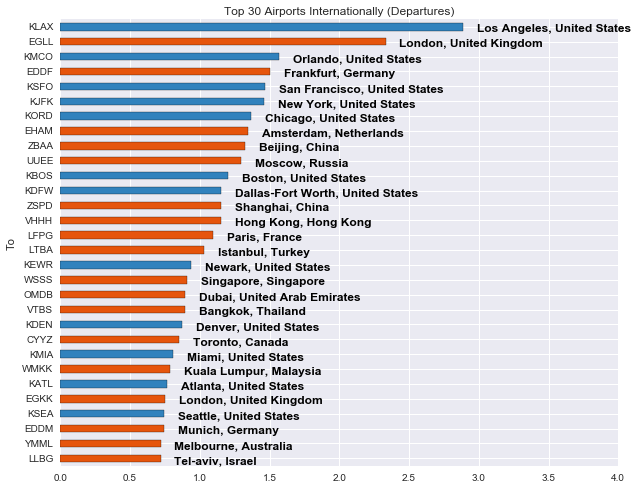

In [223]:
d = airports.sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From (%)'].plot(kind='barh', figsize=(10,8), 
                        color=color, title='Top 30 Airports Internationally (Departures)')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
ax.set_xbound(upper=4)
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .10,y + height * .95, label, color='black',fontsize=12, ha='left', va='top', weight='heavy')

Below is a plot of the top 30 international arrival airports.

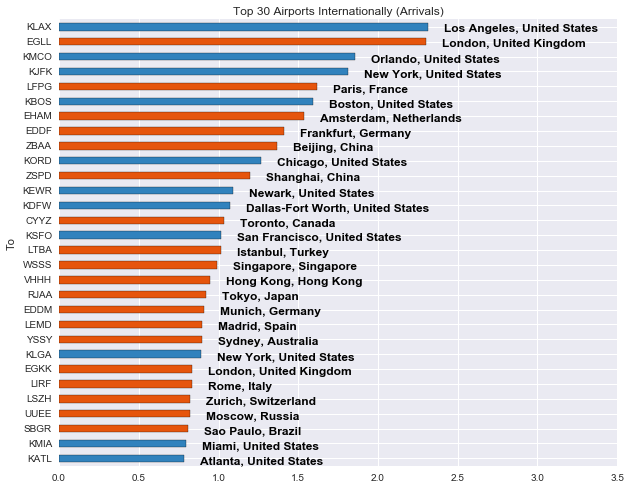

In [224]:
d = airports.sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To (%)'].plot(kind='barh', figsize=(10,8), 
            color=color, title='Top 30 Airports Internationally (Arrivals)')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
ax.set_xbound(upper=3.5)
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .1,y + height * .95, label, color='black',fontsize=12, ha='left', va='top', weight='heavy')

# Here is similar data for flights that start or stop in the US

In [230]:
usa_airports = pd.DataFrame()
usa_airports['From'] = day_of_data_df.groupby(["From"]).Id.nunique()
usa_airports['To'] = day_of_data_df.groupby(["To"]).Id.nunique()
usa_airports['From'] = usa_airports['From'].fillna(0).map(np.int64)
usa_airports['To'] = usa_airports['To'].fillna(0).map(np.int64)
usa_airports['From (%)'] = usa_airports['From']/usa_airports['From'].sum() * 100
usa_airports['To (%)'] = usa_airports['To']/usa_airports['To'].sum() * 100
usa_airports['Country'] = [country_lu(code) for code in usa_airports.index.values]
usa_airports['Domestic'] = usa_airports.index.isin(us_airports)
usa_airports.index.name = 'Airport'
usa_airports.sort_values(by='To',ascending=False).head(5)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
KLAX,203,261,2.241360,2.981154,United States,True
EGLL,202,211,2.230319,2.410051,United Kingdom,False
KMCO,163,142,1.799713,1.621930,United States,True
EDDF,124,136,1.369107,1.553398,Germany,False
KSFO,89,133,0.982665,1.519132,United States,True


In [541]:
usa_airports.groupby(usa_airports['Domestic']).sum()

,From,To,From (%),To (%)
Domestic,,,,
False,531,520,17.313336,17.339113
True,2536,2479,82.686664,82.660887


The top 30 airports where the destination is in the US.

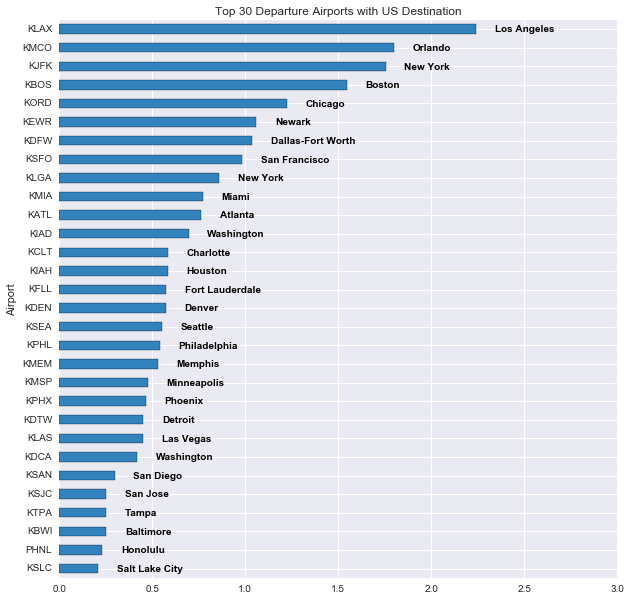

In [266]:
d = usa_airports[usa_airports.To.index.isin(us_airports)].sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),
                 palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From (%)'].plot(kind='barh', figsize=(10,10), color=color,
            title='Top 30 Departure Airports with US Destination')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
ax.set_xbound(upper=3)
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .1,y + height * .95, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

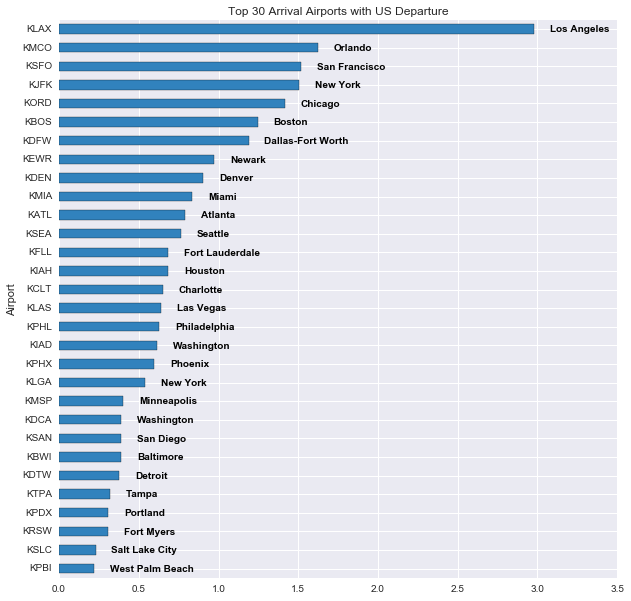

In [269]:
d = usa_airports[usa_airports.From.index.isin(us_airports)].sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports), palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To (%)'].plot(kind='barh', figsize=(10,10), color=color,
            title='Top 30 Arrival Airports with US Departure')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
ax.set_xbound(upper=3.5)
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .1,y + height * .95, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

In [284]:
international = usa_airports[~usa_airports.From.index.isin(us_airports)]
international = international[~international.To.index.isin(us_airports)]
international.sort_values(by='From',ascending=False).head(10)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
EGLL,202,211,2.230319,2.410051,United Kingdom,False
LFPG,142,99,1.567848,1.130782,France,False
EHAM,135,122,1.490560,1.393489,Netherlands,False
EDDF,124,136,1.369107,1.553398,Germany,False
ZBAA,120,120,1.324942,1.370645,China,False
ZSPD,105,104,1.159324,1.187893,China,False
CYYZ,91,77,1.004748,0.879497,Canada,False
LTBA,89,93,0.982665,1.062250,Turkey,False
WSSS,87,82,0.960583,0.936608,Singapore,False


In [285]:
international_country = international.groupby(international['Country'])
print('Main contries traveled to:\n',', '.join(list(international_country.sum().sort_values(by='To',
                                                                                 ascending=False).head(20).index)))
print('Main countries traveled from:\n', ', '.join(list(international_country.sum().sort_values(by='From',
                                                                                   ascending=False).head(20).index)))

Main contries traveled to:
 China, United Kingdom, Germany, Russia, Brazil, Australia, Spain, Canada, France, Italy, Turkey, Mexico, Netherlands, Japan, Thailand, United Arab Emirates, Malaysia, Hong Kong, Singapore, Switzerland
Main countries traveled from:
 China, United Kingdom, Germany, Spain, Brazil, Russia, Australia, France, Canada, Italy, Japan, Mexico, Netherlands, Turkey, Switzerland, Malaysia, Thailand, Singapore, United Arab Emirates, Hong Kong


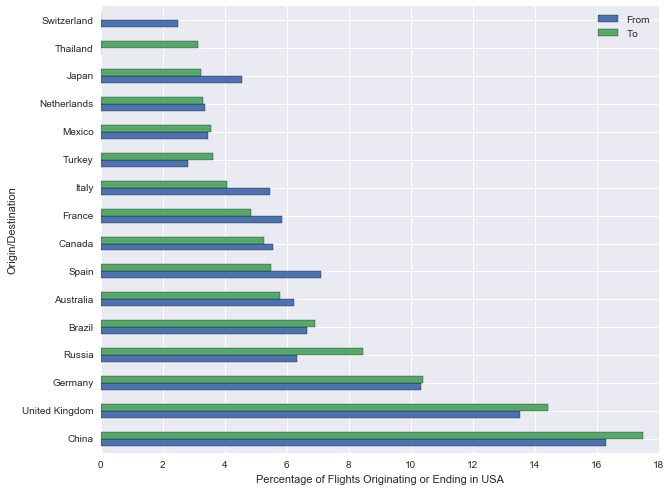

In [286]:
from_ = international_country.sum().sort_values(by='From',ascending=False).head(15)['From']
from_ = from_ / from_.sum() * 100
to_ = international_country.sum().sort_values(by='To',ascending=False).head(15)['To']
to_ = to_ / to_.sum() * 100
ax = pd.concat([from_, to_], axis=1).sort_values(by='To',ascending=False).plot(kind='barh', figsize=(10,8))
ax.set_xlabel('Percentage of Flights Originating or Ending in USA')
ax.set_ylabel('Origin/Destination')

And Atlanta...

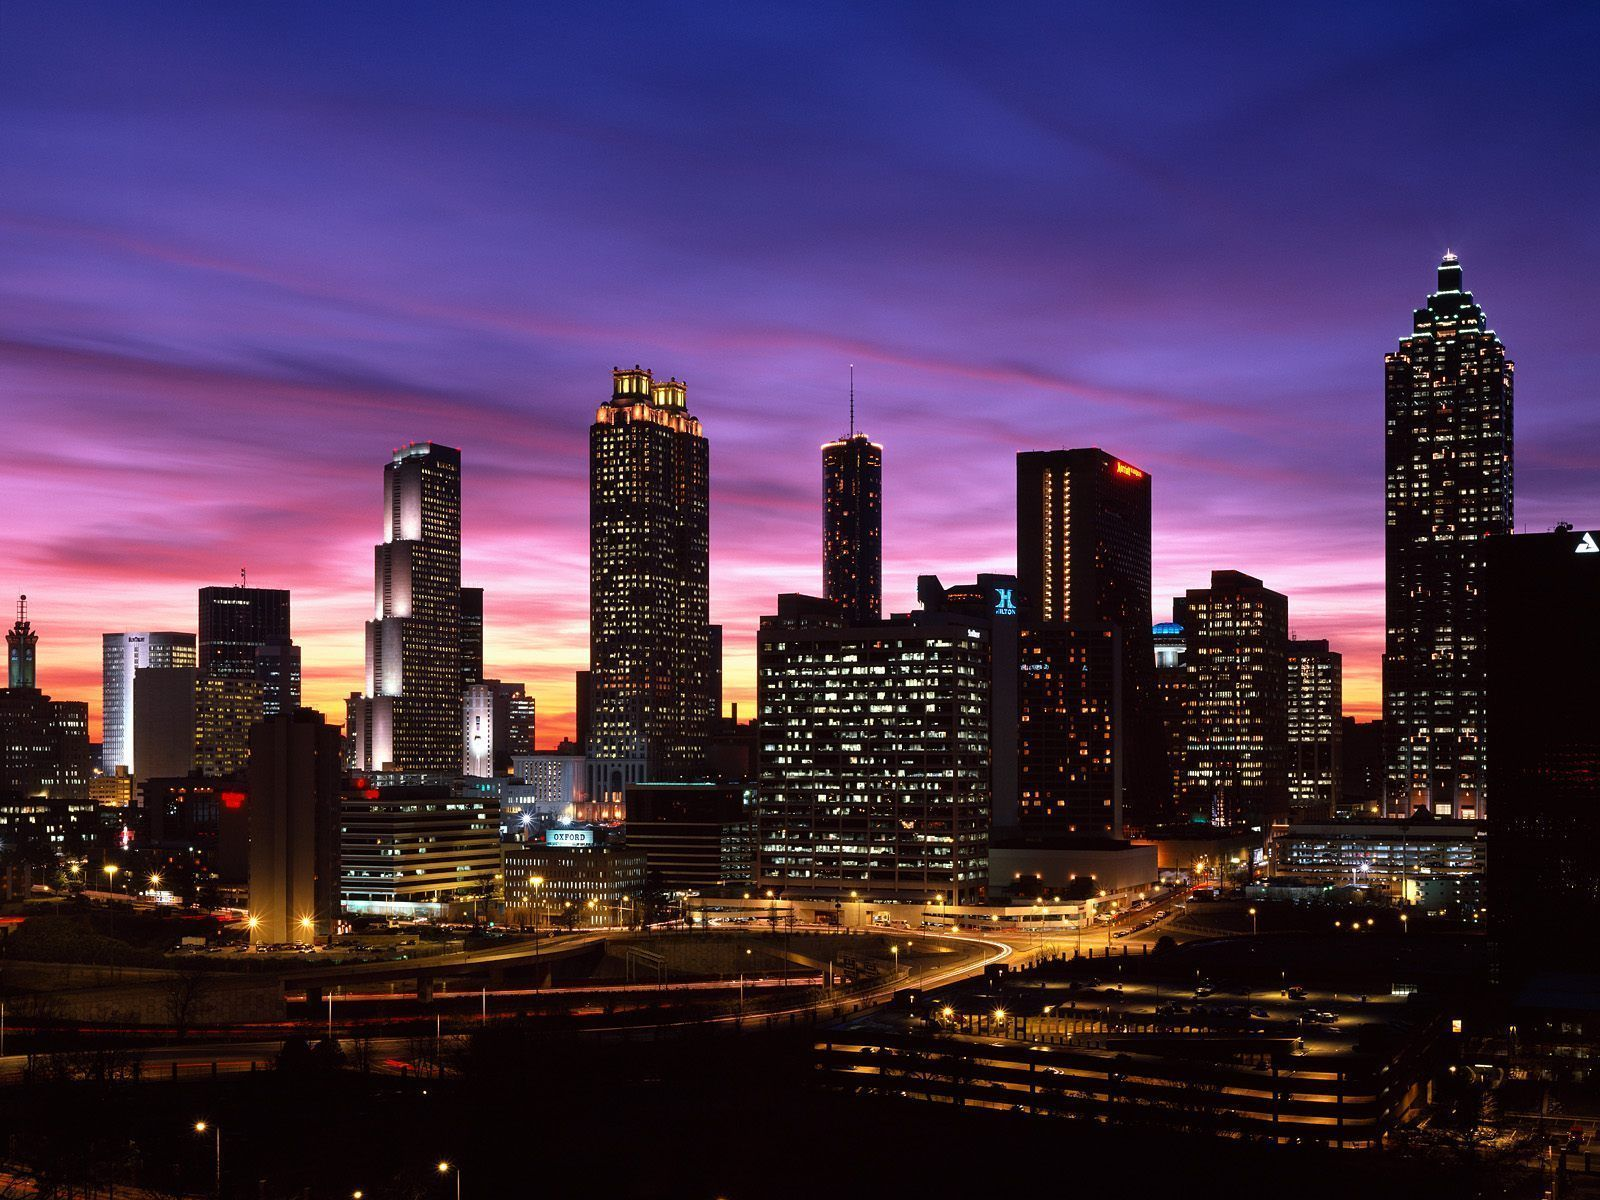

In [288]:
Image("http://wallpapercave.com/wp/E48LtWF.jpg")

In [557]:
atl_ = store.select('data',where='From = "KATL" | To = "KATL"').drop_duplicates()
atl = pd.DataFrame()
atl['From'] = atl_.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
atl['To'] = atl_.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
atl['From'] = atl['From'].fillna(0).map(np.int64)
atl['To'] = atl['To'].fillna(0).map(np.int64)
atl['From (%)'] = atl['From']/airports['From'].sum() * 100
atl['To (%)'] = atl['To']/airports['To'].sum() * 100
atl['Country'] = [country_lu(code) for code in atl.index.values]
atl.drop('KATL', inplace=True)
atl.sort_values(by='To',ascending=False).head(20)

,From,To,From (%),To (%),Country
To,,,,,
KMCO,1,5,0.011049,0.056928,United States
KDFW,2,4,0.022097,0.045543,United States
LFPG,1,3,0.011049,0.034157,France
KLGA,1,2,0.011049,0.022771,United States
KSEA,3,2,0.033146,0.022771,United States
KEWR,1,2,0.011049,0.022771,United States
KORD,1,2,0.011049,0.022771,United States
KLAX,5,1,0.055243,0.011386,United States
KMSP,1,1,0.011049,0.011386,United States
